In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:
ticker = yf.Ticker('GC=F')
df = ticker.history(start='2016-01-01', end='2025-01-01')
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2016-01-04 00:00:00-05:00,1063.400024,1082.500000,1063.199951,1075.099976,143,0.0,0.0
1,2016-01-05 00:00:00-05:00,1075.599976,1081.500000,1075.300049,1078.400024,82,0.0,0.0
2,2016-01-06 00:00:00-05:00,1081.599976,1093.699951,1081.599976,1091.900024,52,0.0,0.0
3,2016-01-07 00:00:00-05:00,1091.599976,1109.400024,1091.599976,1107.699951,122,0.0,0.0
4,2016-01-08 00:00:00-05:00,1111.099976,1111.099976,1093.000000,1097.800049,98,0.0,0.0


In [3]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

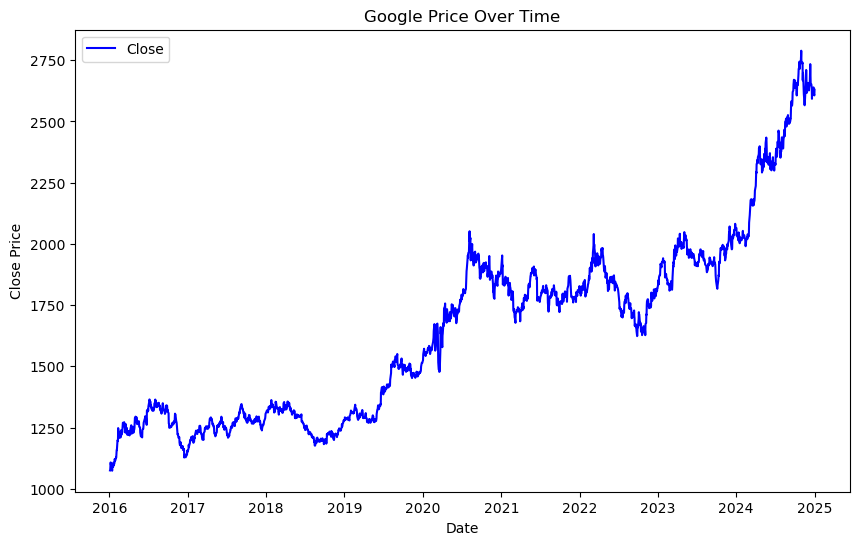

In [4]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label='Close', color='blue')
plt.title('Google Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show();

In [5]:
# MACD
def compute_macd(data, short=12, long=26, signal=9):
    ema_short = data['Close'].ewm(span=short, adjust=False).mean()
    ema_long = data['Close'].ewm(span=long, adjust=False).mean()

    # MACD line
    macd = ema_short - ema_long

    # Signal line (EMA of MACD)
    signal_line = macd.ewm(span=signal, adjust=False).mean()

    data['MACD'] = macd
    data['Signal'] = signal_line

    return data

df = compute_macd(df)

In [6]:
# RSI
def compute_rsi(data, period=14):
    delta = data['Close'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    data['RSI'] = rsi
    return data

df = compute_rsi(df)

In [7]:
# Bollinger Bands
def compute_bollinger_bands(data, period=20, std_multiplier=2):
    sma = data['Close'].rolling(window=period).mean()
    std = data['Close'].rolling(window=period).std()

    upper_band = sma + std_multiplier * std
    lower_band = sma - std_multiplier * std

    data['BB_Middle'] = sma
    data['BB_Upper'] = upper_band
    data['BB_Lower'] = lower_band

    return data

df = compute_bollinger_bands(df)

In [8]:
# Moving Average
def compute_ma(data, period=20):
    data[f'SMA_{period}'] = data['Close'].rolling(window=period).mean()
    return data
    
df = compute_ma(df)

In [9]:
df['Lag7'] = df['Close'].shift(7)

In [10]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal,RSI,BB_Middle,BB_Upper,BB_Lower,SMA_20,Lag7
0,2016-01-04,1063.400024,1082.500000,1063.199951,1075.099976,143,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-05,1075.599976,1081.500000,1075.300049,1078.400024,82,0.0,0.0,0.263252,0.052650,100.000000,NaN,NaN,NaN,NaN,NaN
2,2016-01-06,1081.599976,1093.699951,1081.599976,1091.900024,52,0.0,0.0,1.543426,0.350806,100.000000,NaN,NaN,NaN,NaN,NaN
3,2016-01-07,1091.599976,1109.400024,1091.599976,1107.699951,122,0.0,0.0,3.789216,1.038488,100.000000,NaN,NaN,NaN,NaN,NaN
4,2016-01-08,1111.099976,1111.099976,1093.000000,1097.800049,98,0.0,0.0,4.715820,1.773954,72.409361,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,2024-12-24,2613.000000,2620.000000,2609.500000,2620.000000,35,0.0,0.0,-9.144972,-3.899556,43.499011,2647.054993,2710.452758,2583.657227,2647.054993,2656.000000
2257,2024-12-26,2628.500000,2638.800049,2627.899902,2638.800049,84,0.0,0.0,-8.295974,-4.778840,50.014975,2647.979993,2710.264178,2585.695807,2647.979993,2651.399902
2258,2024-12-27,2617.699951,2617.699951,2616.399902,2617.199951,642,0.0,0.0,-9.259349,-5.674941,43.382418,2646.844995,2710.560031,2583.129959,2646.844995,2644.399902
2259,2024-12-30,2620.699951,2626.899902,2597.000000,2606.100098,794,0.0,0.0,-10.794069,-6.698767,40.219910,2644.300000,2710.331269,2578.268731,2644.300000,2636.500000


In [11]:
df.dropna(inplace=True)
df = df.drop(['Dividends','Stock Splits'],axis=1)

In [12]:
df.shape

(2242, 14)

In [13]:
df = df.reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume,MACD,Signal,RSI,BB_Middle,BB_Upper,BB_Lower,SMA_20,Lag7
0,2016-02-01,1116.699951,1130.000000,1115.300049,1127.900024,1682,10.661101,7.902684,73.209002,1099.154993,1130.110597,1068.199388,1099.154993,1099.099976
1,2016-02-02,1128.300049,1131.400024,1123.000000,1127.300049,1230,11.344124,8.590972,72.255330,1101.764996,1132.982208,1070.547785,1101.764996,1097.199951
2,2016-02-03,1128.500000,1146.000000,1125.000000,1141.300049,1630,12.866787,9.446135,79.459546,1104.909998,1138.777295,1071.042700,1104.909998,1106.199951
3,2016-02-04,1142.500000,1157.599976,1141.000000,1157.599976,771,15.213406,10.599589,84.771640,1108.194995,1148.820035,1067.569955,1108.194995,1121.699951
4,2016-02-05,1155.599976,1174.800049,1146.000000,1157.800049,877,16.894513,11.858574,84.827214,1110.700000,1156.981259,1064.418741,1110.700000,1116.099976


In [14]:
df = df.set_index('Date')

In [15]:
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

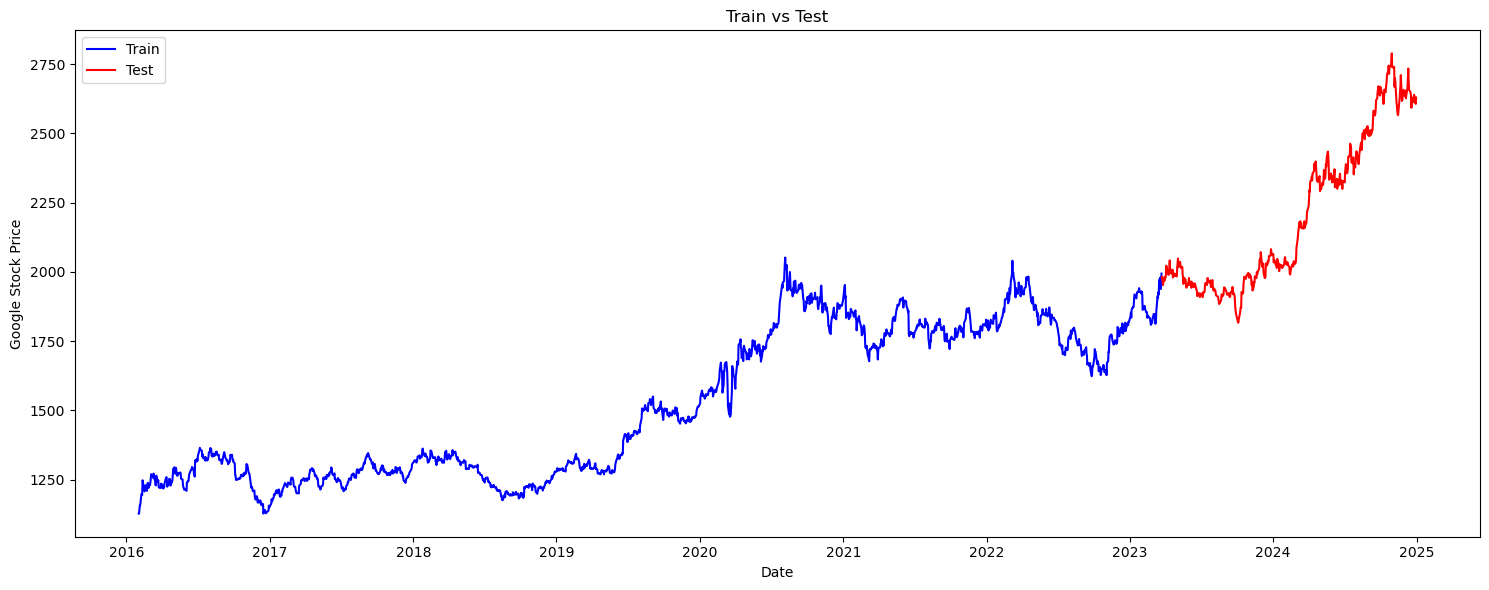

In [16]:
fig, ax = plt.subplots(figsize=(15,6))
# training data
sns.lineplot(x=df.index[:1796], y=df['Close'][:1796], color='blue', label='Train', ax=ax)
# testing data
sns.lineplot(x=df.index[1796:], y=df['Close'][1796:], color='red', label='Test', ax=ax)

ax.set_title('Train vs Test')
ax.set_xlabel('Date')
ax.set_ylabel('Google Stock Price')
plt.legend()
plt.tight_layout()
plt.show();

In [17]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

In [18]:
def create_sequence(data, window=3):
    x, y = [], []
    for i in range(len(data) - window):
        x.append(data[i:i+window])
        y.append(data[i+window, 3])
    return np.array(x), np.array(y)

In [19]:
x_train, y_train = create_sequence(train_scaled, window=3)
x_test, y_test = create_sequence(test_scaled, window=3)

In [20]:
x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_test_2d = x_test.reshape(x_test.shape[0], -1)

<h2>Machine Learning</h2>

In [21]:
model = Ridge()
model.fit(x_train_2d, y_train)
y_pred = model.predict(x_test_2d)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared:", r2_score(y_test, y_pred))

MAE: 0.017579185943719745
RMSE: 0.02294686557386
R-squared: 0.9939800028082438


In [22]:
# Number of features
n_features = train_scaled.shape[1]

y_pred_full = np.zeros((len(y_pred), n_features))
y_pred_full[:, 3] = y_pred 

y_pred_original = scaler.inverse_transform(y_pred_full)[:, 3]

y_test_full = np.zeros((len(y_test), n_features))
y_test_full[:, 3] = y_test
y_test_original = scaler.inverse_transform(y_test_full)[:, 3]

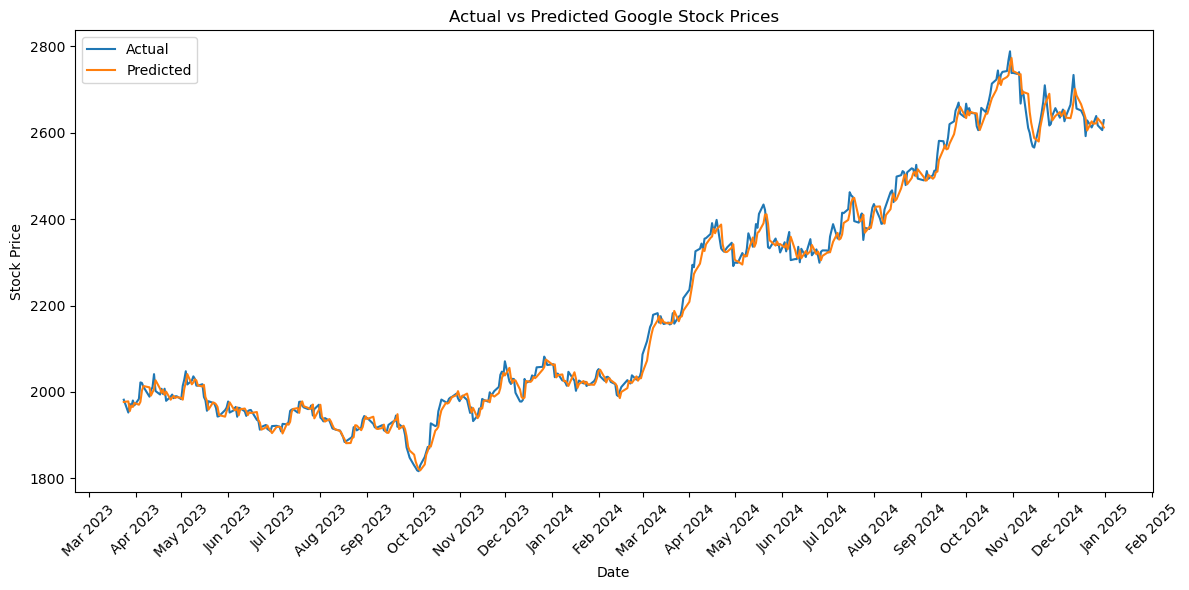

In [23]:
window=3
test_dates = test_df.index[window:]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_original, label='Actual')
plt.plot(test_dates, y_pred_original, label='Predicted')

# Format the x-axis to show dates monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title('Actual vs Predicted Google Stock Prices')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show();

In [24]:
results_df = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_pred_original
}, index=test_dates)

results_df.index.name = 'Date'
results_df.head()

,Actual,Predicted
Date,,
2023-03-24,1982.099976,1976.873954
2023-03-27,1952.400024,1978.329667
2023-03-28,1972.400024,1955.860245
2023-03-29,1966.099976,1968.347713
2023-03-30,1980.300049,1965.425265


<h2>Deep Learning</h2>

In [25]:
model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True)),
model.add(LSTM(units=64, activation='relu')),
model.add(Dropout(0.3)),
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(x_train, y_train, epochs=30, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0853 - mae: 0.1958 - val_loss: 0.2050 - val_mae: 0.3035
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0554 - val_loss: 0.0932 - val_mae: 0.2015
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - mae: 0.0527 - val_loss: 0.0308 - val_mae: 0.1129
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - mae: 0.0514 - val_loss: 0.0065 - val_mae: 0.0714
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mae: 0.0487 - val_loss: 0.0079 - val_mae: 0.0612
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0050 - mae: 0.0472 - val_loss: 0.0229 - val_mae: 0.1040
Epoch 7/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - mae: 0.0496 - val_loss: 0.0258 - val_mae: 0.1174
Epoch 8/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - mae: 0.0459 - val_loss: 0.0132 - val_mae: 0.0743
Epoch 9/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

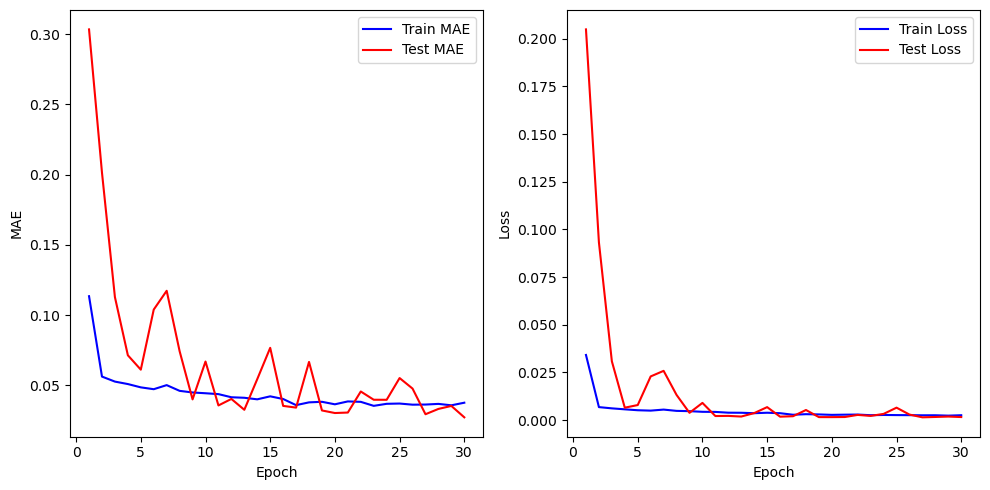

In [26]:
# learning curve
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# creating subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(epochs, mae, 'b', label='Train MAE')
axes[0].plot(epochs, val_mae, 'r', label='Test MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# adusting layout for better spacing
plt.tight_layout()
# display the figure
plt.show();

In [27]:
# Predict
y_pred = model.predict(x_test).flatten()

window=3
n_features = train_scaled.shape[1]

y_pred_full = np.zeros((len(y_pred), n_features))
y_pred_full[:, 3] = y_pred
y_pred_original = scaler.inverse_transform(y_pred_full)[:, 3]

y_test_full = np.zeros((len(y_test), n_features))
y_test_full[:, 3] = y_test
y_test_original = scaler.inverse_transform(y_test_full)[:, 3]

test_dates = test_df.index[window:]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [28]:
print("MAE:", mean_absolute_error(y_test_original, y_pred_original))
print("RMSE:", np.sqrt(mean_squared_error(y_test_original, y_pred_original)))
print("R²:", r2_score(y_test_original, y_pred_original))

MAE: 25.207134723263376
RMSE: 36.66107331662977
R²: 0.982010130444434


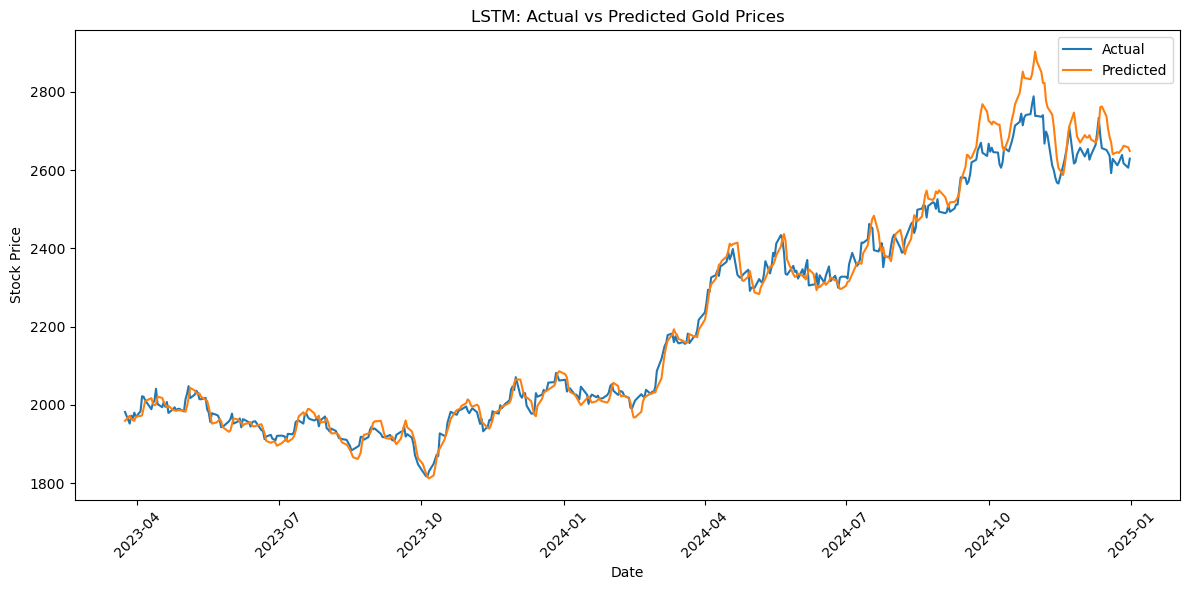

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_original, label='Actual')
plt.plot(test_dates, y_pred_original, label='Predicted')
plt.xticks(rotation=45)
plt.title('LSTM: Actual vs Predicted Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show();

In [30]:
results_df = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_pred_original
}, index=test_dates)

results_df.index.name = 'Date'
results_df.head()

,Actual,Predicted
Date,,
2023-03-24,1982.099976,1959.300880
2023-03-27,1952.400024,1972.202329
2023-03-28,1972.400024,1964.854657
2023-03-29,1966.099976,1961.457796
2023-03-30,1980.300049,1959.201504
